In [3]:
import pyemma
import pickle
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm


molecule = "CLN025"
simulation_num = 0


In [4]:
traj = md.load_dcd(
	f"../DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-protein/{molecule}-0-protein-000.dcd",
	top=f"../data/{molecule}.pdb"
)

view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=9999)

# Descriptors

In [5]:
# Alpha carbon distances
state_traj = md.load(f"../data/{molecule}.pdb")
ca_atoms = state_traj.topology.select("name CA")
n_atoms = len(ca_atoms)	
atom_pairs = []
for i in range(n_atoms):
    for j in range(i+1, n_atoms):
        atom_pairs.append([ca_atoms[i], ca_atoms[j]])
print(atom_pairs)

[[np.int64(4), np.int64(25)], [np.int64(4), np.int64(46)], [np.int64(4), np.int64(60)], [np.int64(4), np.int64(72)], [np.int64(4), np.int64(87)], [np.int64(4), np.int64(101)], [np.int64(4), np.int64(108)], [np.int64(4), np.int64(122)], [np.int64(4), np.int64(146)], [np.int64(25), np.int64(46)], [np.int64(25), np.int64(60)], [np.int64(25), np.int64(72)], [np.int64(25), np.int64(87)], [np.int64(25), np.int64(101)], [np.int64(25), np.int64(108)], [np.int64(25), np.int64(122)], [np.int64(25), np.int64(146)], [np.int64(46), np.int64(60)], [np.int64(46), np.int64(72)], [np.int64(46), np.int64(87)], [np.int64(46), np.int64(101)], [np.int64(46), np.int64(108)], [np.int64(46), np.int64(122)], [np.int64(46), np.int64(146)], [np.int64(60), np.int64(72)], [np.int64(60), np.int64(87)], [np.int64(60), np.int64(101)], [np.int64(60), np.int64(108)], [np.int64(60), np.int64(122)], [np.int64(60), np.int64(146)], [np.int64(72), np.int64(87)], [np.int64(72), np.int64(101)], [np.int64(72), np.int64(108)], 

In [6]:
# Load traj data
for simulation_idx in range(simulation_num + 1):
	traj_list = []
	for i in tqdm(
		range(53),
		desc="Loading trajectories"
	):
		file_idx = f"{i:03d}"
		traj = md.load_dcd(
			f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein-{file_idx}.dcd",
			top=f"../data/{molecule}.pdb"
		)
		traj_list.append(traj)
	all_traj = md.join(traj_list)

	# featurizer
	feat_torsions = pyemma.coordinates.featurizer(f"../data/{molecule}.pdb")
	feat_torsions.add_backbone_torsions(cossin=True)
	feature_torsions = feat_torsions.transform(all_traj)
	print(feature_torsions.shape)

	feat_dist = pyemma.coordinates.featurizer(f"../data/{molecule}.pdb")
	feat_dist.add_distances(indices=atom_pairs)
	feature_distances = feat_dist.transform(all_traj)
	print(feature_distances.shape)

	feat = pyemma.coordinates.featurizer(f"../data/{molecule}.pdb")
	feat.add_distances(indices=atom_pairs)
	feat.add_backbone_torsions(cossin=True)
	feature_all = feat.transform(all_traj)
	print(feature_all.shape)
 
	torch.save(feature_distances, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")
	print(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt saved")
	torch.save(feature_torsions, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-dihedral.pt")
	print(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-dihedral.pt saved")
	torch.save(feature_all, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-dihedral.pt")
	print(f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-dihedral.pt saved")

Loading trajectories: 100%|██████████| 53/53 [00:01<00:00, 36.88it/s]


(530000, 36)
(530000, 45)
(530000, 81)
../DESRES-Trajectory_CLN025-0-protein/CLN025-0-CAdistance.pt saved
../DESRES-Trajectory_CLN025-0-protein/CLN025-0-dihedral.pt saved
../DESRES-Trajectory_CLN025-0-protein/CLN025-0-CAdistance-dihedral.pt saved


# TICA

In [7]:
feature_distances_mean = feature_distances.mean()
feature_distances_std = feature_distances.std()
feature_distances_normalized = (feature_distances - feature_distances_mean) / feature_distances_std

print(feature_distances_normalized.shape)

(530000, 45)


/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


(530000, 2)
[[-5.698862   5.0449343]]


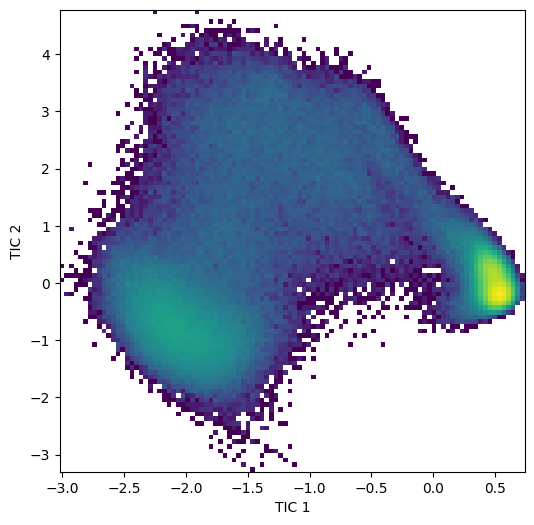

In [8]:
data = feature_distances_normalized
tica_obj = pyemma.coordinates.tica(data, lag=5, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]
print(tica_data.shape)

# State information
state_traj = md.load(f"../data/{molecule}.pdb")
state_feat = feat_dist.transform(state_traj)
tica_state = tica_obj.transform(state_feat)
print(tica_state)

# Plot
plt.figure(figsize=(6, 6))
plt.hist2d(x, y, bins=100, norm=LogNorm())
# plt.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
# plt.gca().invert_yaxis()
plt.show()

with open(f'../data/{molecule}_tica_model.pkl', 'wb') as f:
    pickle.dump(tica_obj, f)

# Label

In [10]:
base_dir = "../DESRES-Trajectory_CLN025-0-protein"

pdb_path = "../data/CLN025.pdb"
traj = md.load_pdb(pdb_path)
view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget()

In [32]:
donor_idx = traj.topology.select('residue 7 and name N')[0]
acceptor_idx = traj.topology.select('residue 3 and name O')[0]
print(donor_idx, acceptor_idx)

99 55


In [42]:
def label_by_hbond(traj, distance_cutoff=0.35, angle_cutoff=110, bond_number_cutoff=3):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx, hydrogen_idx, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx_1, hydrogen_idx_2, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle_1 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_1, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_2, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle_1[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	hydrogen_idx = 45
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	hydrogen_idx = 92
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	hydrogen_idx = 100
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	hydrogen_idx = 145
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)




	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + labels_ASP3N_TYR8O + labels_THR6OG1_ASP3O \
		+ labels_THR6N_ASP3OD1 + labels_THR6N_ASP3OD2 + labels_GLY7N_ASP3O + labels_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum

file_idx = "000"
traj = md.load_dcd(
    f"./{base_dir}/CLN025-0-protein/CLN025-0-protein-{file_idx}.dcd",
    top=f"../data/CLN025.pdb"
)
label, bond_sum = label_by_hbond(traj)

print("Label statistics")
print(label.sum())
print(label.shape)


Label statistics
5466
(10000,)


In [45]:
label_list = []
bond_num_list = []

for i in tqdm(
    range(53),
    desc="Computing labels"
):
    file_idx = f"{i:03d}"
    traj = md.load_dcd(
		f"./{base_dir}/CLN025-0-protein/CLN025-0-protein-{file_idx}.dcd",
		top=f"../data/CLN025.pdb"
    )
    label, bond_num = label_by_hbond(traj)
    label_list.append(label)
    bond_num_list.append(bond_num)

label_array = np.concatenate(label_list, axis=0)
bond_num_array = np.concatenate(bond_num_list, axis=0)
label_torch = torch.from_numpy(label_array)
bond_num_torch = torch.from_numpy(bond_num_array)
print(label_torch.shape)
print(bond_num_torch.shape)

Computing labels: 100%|██████████| 53/53 [02:11<00:00,  2.48s/it]

torch.Size([530000])
torch.Size([530000])


In [52]:
label_torch = label_torch.to(dtype=torch.float32)
torch.save(label_torch, "../DESRES-Trajectory_CLN025-0-protein/CLN025-label_all.pt")
bond_num_torch = bond_num_torch.to(dtype=torch.float32)
torch.save(bond_num_torch, "../DESRES-Trajectory_CLN025-0-protein/CLN025-bond_num.pt")

In [53]:
bond_num_torch.max()

tensor(5.)

## TICA & labels

In [36]:
with open(f'../data/CLN025_tica_model.pkl', 'rb') as f:
    tica = pickle.load(f)
print(tica)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [38]:
# Load traj data
traj_list = []
for i in tqdm(
    range(53),
    desc="Loading trajectories"
):  # 0 to 52 inclusive
    file_idx = f"{i:03d}"
    traj = md.load_dcd(
        f"{base_dir}/CLN025-0-protein/CLN025-0-protein-{file_idx}.dcd",
        top="../data/CLN025.pdb"
    )
    traj_list.append(traj)
all_traj = md.join(traj_list)

state_traj = md.load("../data/CLN025.pdb")
ca_atoms = state_traj.topology.select("name CA")
n_atoms = len(ca_atoms)	
atom_pairs = []
for i in range(n_atoms):
    for j in range(i+1, n_atoms):
        atom_pairs.append([ca_atoms[i], ca_atoms[j]])
print(atom_pairs)

Loading trajectories: 100%|██████████| 53/53 [00:01<00:00, 37.47it/s]


[[np.int64(4), np.int64(25)], [np.int64(4), np.int64(46)], [np.int64(4), np.int64(60)], [np.int64(4), np.int64(72)], [np.int64(4), np.int64(87)], [np.int64(4), np.int64(101)], [np.int64(4), np.int64(108)], [np.int64(4), np.int64(122)], [np.int64(4), np.int64(146)], [np.int64(25), np.int64(46)], [np.int64(25), np.int64(60)], [np.int64(25), np.int64(72)], [np.int64(25), np.int64(87)], [np.int64(25), np.int64(101)], [np.int64(25), np.int64(108)], [np.int64(25), np.int64(122)], [np.int64(25), np.int64(146)], [np.int64(46), np.int64(60)], [np.int64(46), np.int64(72)], [np.int64(46), np.int64(87)], [np.int64(46), np.int64(101)], [np.int64(46), np.int64(108)], [np.int64(46), np.int64(122)], [np.int64(46), np.int64(146)], [np.int64(60), np.int64(72)], [np.int64(60), np.int64(87)], [np.int64(60), np.int64(101)], [np.int64(60), np.int64(108)], [np.int64(60), np.int64(122)], [np.int64(60), np.int64(146)], [np.int64(72), np.int64(87)], [np.int64(72), np.int64(101)], [np.int64(72), np.int64(108)], 

In [39]:
feat_dist = pyemma.coordinates.featurizer("../data/CLN025.pdb")
feat_dist.add_distances(indices=atom_pairs)
feature_distances = feat_dist.transform(all_traj)
tica_coord = tica.transform(feature_distances)
print(tica_coord.shape)

(530000, 2)


In [43]:
bond_sum.max()

np.int64(4)

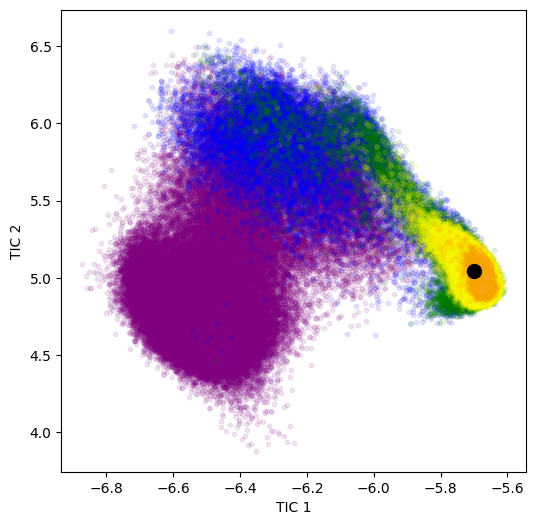

In [49]:
state_traj = md.load("../data/CLN025.pdb")
state_feat = feat_dist.transform(state_traj)
tica_state = tica.transform(state_feat)
label_mask = label_torch == 1
color=["purple", "blue", "green", "yellow", "orange", "pink", "red", "maroon", "gray"]
# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(tica_state[:, 0], tica_state[:, 1], c='black', s=100, zorder=101)
for i in range(9):
    label_mask = bond_num_array == i
    ax.scatter(tica_coord[label_mask, 0], tica_coord[label_mask, 1], c=color[i], s=10, alpha=0.1)
# ax.set_xlim(-7, -5)
# ax.set_ylim(4, 7)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.show()

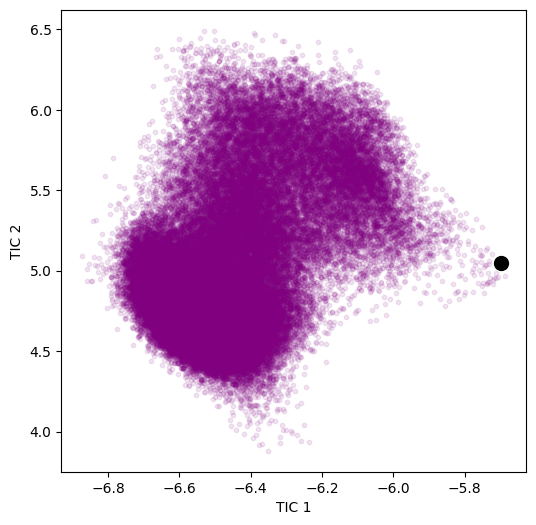

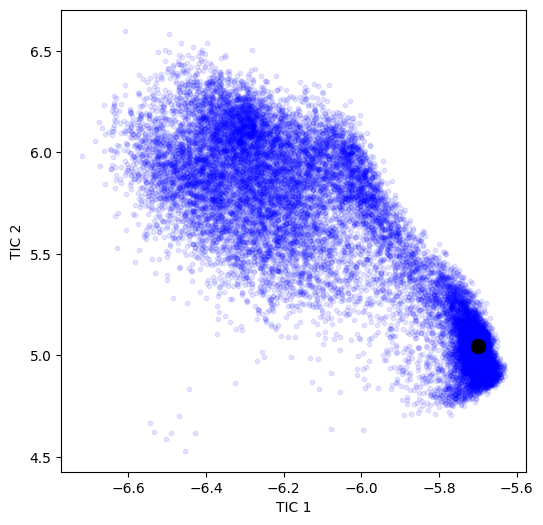

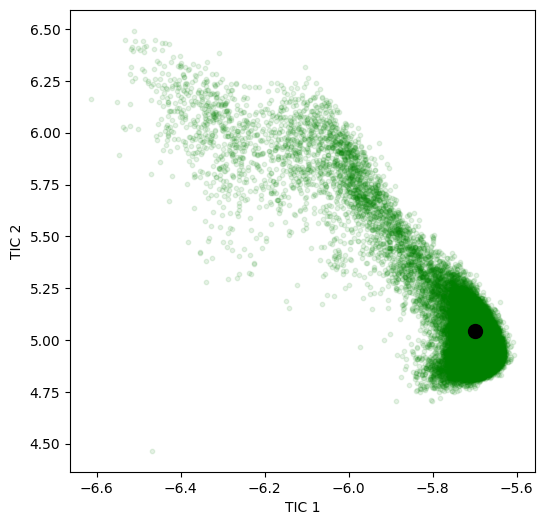

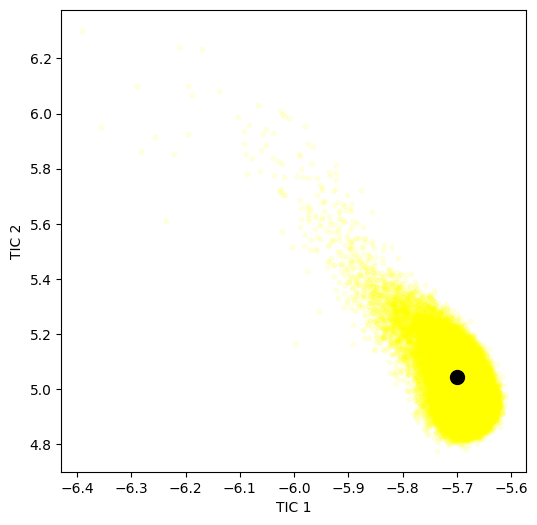

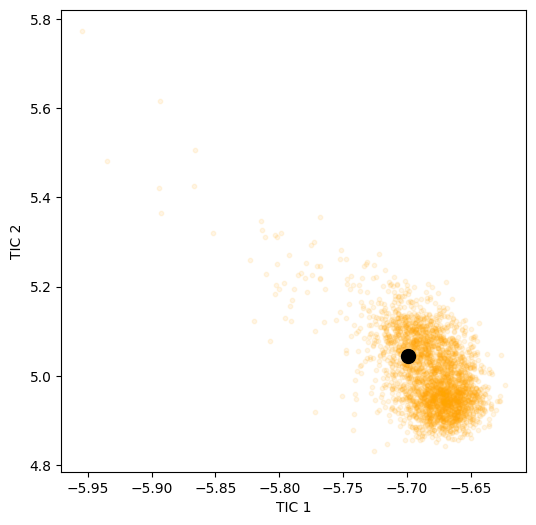

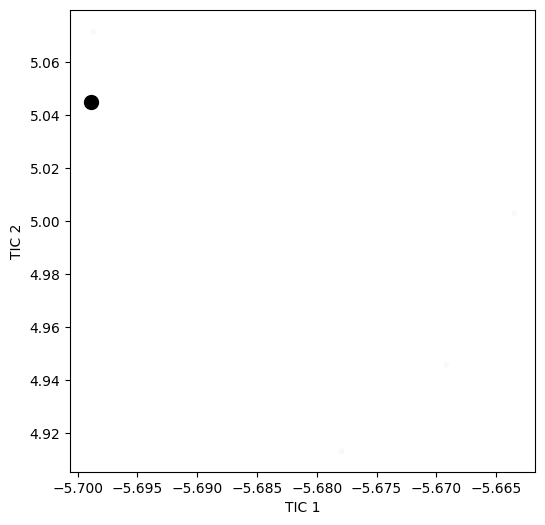

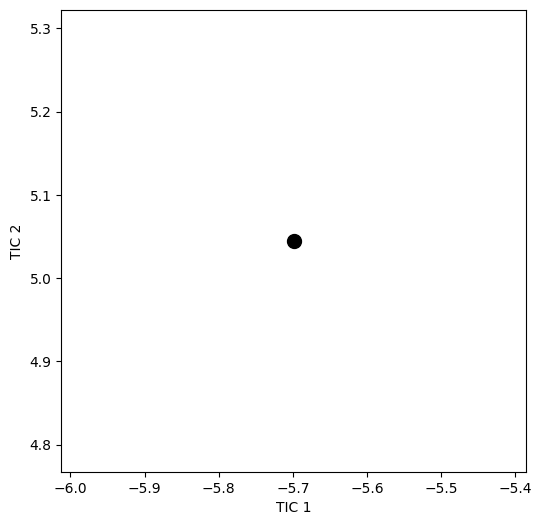

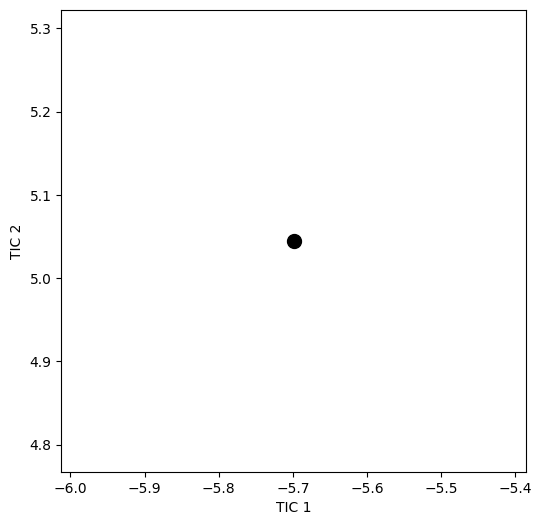

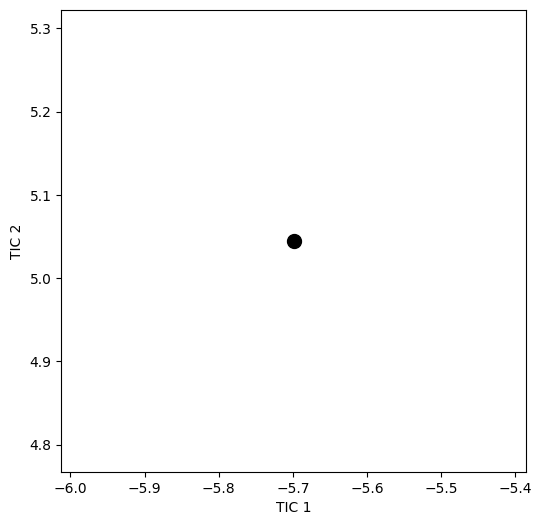

In [50]:
color=["purple", "blue", "green", "yellow", "orange", "pink", "red", "maroon", "gray"]
# Plot
for i in range(9):
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)

	label_mask = bond_num_array == i
	ax.scatter(tica_state[:, 0], tica_state[:, 1], c='black', s=100, zorder=101)
	ax.scatter(tica_coord[label_mask, 0], tica_coord[label_mask, 1], c=color[i], s=10, alpha=0.1)

	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.show()